## Exercise 2.1:


In [6]:
import numpy as np
import time
import pandas as pd
import scipy.optimize as opt
from matplotlib import pyplot as plt

In [7]:
beta_annual = 0.96
beta = beta_annual ** (20)
delta_annual = 0.05
delta = 1 - (1 - delta_annual) ** 20
sigma = 3.0
A = 1.0
alpha = 0.35
n_vec = np.array([1.0, 1.0, 0.2])
f_params = (n_vec, A, alpha, delta)

In [10]:
def get_r(f_params, bvec_guess):
    (n_vec, A, alpha, delta) = f_params
    r = (alpha * A * (np.sum(n_vec) / np.sum(bvec_guess)) ** (1 - alpha)) - delta
    return r

def get_w(f_params, bvec_guess):
    """Get the wage for the current time period"""
    (n_vec, A, alpha, delta) = f_params
    w = (1 - alpha) * A * (np.sum(bvec_guess) / np.sum(n_vec)) ** alpha
    return w

def feasible(f_params, bvec_guess):
    """Uses steady state parameters to check if there is a constraint violation."""
    (n_vec, A, alpha, delta) = f_params
    b_cnstr = [False, False]
    c_cnstr = [False, False, False]  
    K_cnstr = False                  
    c = [0, 0 , 0]                   #initialize c
    K = np.sum(bvec_guess)
    c[0] = get_w(f_params, bvec_guess)- bvec_guess[0]
    c[1] = get_w(f_params, bvec_guess) + (1 + get_r(f_params, bvec_guess))* bvec_guess[0] - bvec_guess[1]
    c[2] = 0.2 * get_w(f_params, bvec_guess) + (1 + get_r(f_params, bvec_guess))*bvec_guess[1]
    if K <= 0:
        K_cnstr = True
    for s in range(len(c_cnstr)):
        if c[s] <=0:
            c_cnstr[s] = True
    if c_cnstr[0] == True:
        b_cnstr[0] = True
    if c_cnstr[1] == True:
        b_cnstr[0] = True
        b_cnstr[1] = True
    if c_cnstr[2] == True:
        b_cnstr[1] = True
    return b_cnstr, c_cnstr, K_cnstr

In [11]:
# a)
bvec_guess = np.array([1.0, 1.2])
output_1 = feasible(f_params, bvec_guess)
print(output_1)
# b)
bvec_guess = np.array([0.06, -0.001])
output_2 = feasible(f_params, bvec_guess)
print(output_2)
# c)
bvec_guess = np.array([0.1, 0.1])
output_3 = feasible(f_params, bvec_guess)
print(output_3)

([True, False], [True, False, False], False)
([False, False], [False, False, False], False)
([False, False], [False, False, False], False)


a) With this initial guess of 1.0 and 1.2 we get the b constraint and the c constraint holding.

b)  There are no constraints violated

c)  There are no constraints violated

## Exercise 2.2

In [12]:
def Euler_error(bvec_guess, euler_params):
    (beta, sigma, n_vec, L, A, alpha, delta) = euler_params
    f_params = (n_vec, A, alpha, delta)
    r_ss = get_r(f_params, bvec_guess)
    w_ss = get_w(f_params, bvec_guess)
    c1_ss = w_ss * n_vec[0] + (1 + r_ss) * 0 - bvec_guess[0]
    c2_ss = w_ss * n_vec[1] + (1 + r_ss) * bvec_guess[0] - bvec_guess[1]
    c3_ss = w_ss * n_vec[2] + (1 + r_ss) * bvec_guess[1] 
    

    uprime_c1 = c1_ss ** (-sigma)
    uprime_c2 = c2_ss ** (-sigma)
    uprime_c3 = c3_ss ** (-sigma)
    
    EulErr_ss = np.empty(2)
    EulErr_ss[0] = beta*(1 + r_ss)*uprime_c2 - uprime_c1
    EulErr_ss[1] = beta*(1 + r_ss)*uprime_c3 - uprime_c2
    
    return EulErr_ss

def get_SS(params, bvec_guess, SS_graphs):
    """Get's the Steady State"""
    start_time = time.clock() # Time the number of seconds it takes to run the steady state program
    (beta, sigma, n_vec, L, A, alpha, delta, SS_tol) = params
    euler_params = (beta, sigma, n_vec, L, A, alpha, delta)
    f_params = (n_vec, A, alpha, delta)
    root = opt.root(Euler_error, bvec_guess, [beta, sigma, n_vec, L, A, alpha, delta], tol=SS_tol)
    
    b_ss = root.x
    r_ss = get_r(f_params, b_ss)
    w_ss = get_w(f_params, b_ss)
    c_ss = np.empty(3)
    c_ss[0] = w_ss * n_vec[0] + (1 + r_ss) * 0 - b_ss[0]
    c_ss[1] = w_ss * n_vec[1] + (1 + r_ss) * b_ss[0] - b_ss[1]
    c_ss[2] = w_ss * n_vec[2] + (1 + r_ss) * b_ss[1]
    
    K_ss = np.sum(b_ss)
    C_ss = np.sum(c_ss)
    I_ss = K_ss - (1 - delta) * K_ss
    #Y_ss = C_ss + I_ss
    Y_ss = A*(K_ss ** alpha)* L ** (1 - alpha)
    
    EulErr_ss = Euler_error(b_ss, euler_params)
    RCerr_ss = Y_ss - C_ss - delta*K_ss
    
    if SS_graphs == True:
        """Writes a figure of the steady-state distribution of consumption and savings if SS-graphs is set to True"""
        plt.bar(['a-Young', 'b-Middle', 'c-Old'], c_ss)
        plt.xlabel("Time Period")
        plt.ylabel("Consumption")
        plt.title(f"Consumption by Age group for beta - {beta}")
        plt.show()
    ss_labels = ["b_ss", 'c_ss', 'w_ss', 'r_ss', 'K_ss', 'Y_ss', 'C_ss', 'EulErr_ss', 'RCerr_ss', 'ss_time']
    ss_time = time.clock() - start_time 
    ss_values = [b_ss, c_ss, w_ss, r_ss, K_ss, Y_ss, C_ss, EulErr_ss, RCerr_ss, ss_time]
    ss_output = dict(zip(ss_labels, ss_values))
    return ss_output

In [13]:
L = np.sum(n_vec)
SS_tol = .001
params = (beta, sigma, n_vec, L, A, alpha, delta, SS_tol)
bvec_guess = np.array([0.1, 0.1])

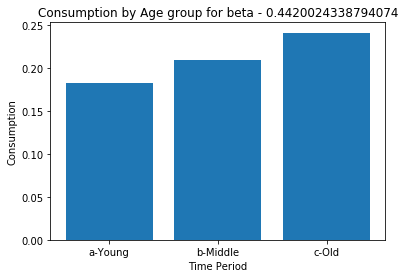

{'C_ss': 0.6329047409324018,
 'EulErr_ss': array([ 0.00253565, -0.00548184]),
 'K_ss': 0.07772574745877081,
 'RCerr_ss': -6.938893903907228e-18,
 'Y_ss': 0.6827669021185218,
 'b_ss': array([0.01931282, 0.05841292]),
 'c_ss': array([0.18241376, 0.20961447, 0.24087651]),
 'r_ss': 2.4329937084963125,
 'ss_time': 0.13250699999999993,
 'w_ss': 0.20172658471683597}

In [14]:
# a) b)
SS = get_SS(params, bvec_guess, True)
SS

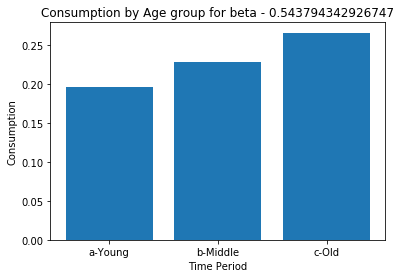

{'C_ss': 0.6882806422350269,
 'EulErr_ss': array([-2.08609578e-06,  4.47879074e-06]),
 'K_ss': 0.10346130886427794,
 'RCerr_ss': 1.5265566588595902e-16,
 'Y_ss': 0.7546525283574993,
 'b_ss': array([0.0276472 , 0.07581411]),
 'c_ss': array([0.19531832, 0.2276436 , 0.26531872]),
 'r_ss': 1.911405345374785,
 'ss_time': 0.12066999999999961,
 'w_ss': 0.2229655197419884}

In [15]:
# c)
beta_annual = 0.97
beta = beta_annual ** (20)
params = (beta, sigma, n_vec, L, A, alpha, delta, SS_tol)
bvec_guess = np.array([0.1, 0.1])
SS = get_SS(params, bvec_guess, True)
SS

When people are more patient, overall consumption rises, capital increases, savings increase, and consumption per period increases as well. The intuition of this is that when we increase 

## Exercise 2.3

In [42]:
# Guess T and define more parameters
T = 30
xi = 0.3
eps = 1e-9

# Define the steady state b and initial b
b2_ss = SS["b_ss"][0]
b3_ss = SS['b_ss'][1]
b21 = 0.8*b2_ss
b31 = 1.1*b3_ss

# Guess {k}^T
k1 = b21 + b31
k_ss = b2_ss + b3_ss
K_path = np.linspace(k1, k_ss, T)
K_path = np.append(K_path, np.array([[k_ss], [k_ss]]))

# Knowing {k}^T gives us {w_t, r_t}^T
W_path = np.empty(T)
R_path = np.empty(T)
for i in range(T):
    W_path[i] = get_w(f_params, K_path[i])
    R_path[i] = get_r(f_params, K_path[i])


In [44]:
# Solve for b32
def get_a_life_equation(b32, get_a_life_params):
    (b21, R_path, W_path, n_vec, beta, sigma) = get_a_life_params  
    error = beta*(1 + R_path[1])*((1 + R_path[1])*b32 + W_path[1]*n_vec[2])**(-sigma) - ((1 + R_path[0])*b21 + W_path[0]*n_vec[1] - b32) ** (-sigma)
    return error

def get_a_life(params, b32):
    (b21, R_path, W_path, n_vec, beta, sigma) = get_a_life_params  
    root = opt.root(get_a_life_equation, b32, [b21, R_path, W_path, n_vec, beta, sigma], tol = 1e-9)
    b32 = root.x
    return b32

get_a_life_params = (b21, R_path, W_path, n_vec, beta, sigma)
b32_guess = 0.1
b32_t2 = get_a_life(get_a_life_params, b32_guess)
b32_t2

array([0.07170167])

In [48]:
def get_lives_error(b, lives_params):
    ( R_path, W_path, n_vec, beta, sigma) = lives_params
    
    error = np.empty(2)
    error[0] = beta*(1 + R_path[1])*((1 + R_path[1])*b[0] + W_path[1]*n_vec[1] - b[1])**(-sigma) - (W_path[0]*n_vec[0] - b[0]) ** (-sigma)
    error[1] = beta*(1 + R_path[2])*((1 + R_path[2])*b[1] + W_path[2]*n_vec[2]) ** (-sigma) - ((1 + R_path[1])*b[0] + W_path[1]*n_vec[1] - b[1])**(-sigma)
    return error

def get_lives(lives_params, b):
    ( R_path, W_path, n_vec, beta, sigma) = lives_params
    root = opt.root(get_lives_error, b, [ R_path, W_path, n_vec, beta, sigma], tol=1e-9)
    b = root.x
    b22 = b[0]
    b33 = b[1]
    return b22, b33

lives_params = ( R_path, W_path, n_vec, beta, sigma)
b22, b32 = get_lives(lives_params, [.1, .1])

In [ ]:
b_guess = np.array([0.1, 0.1])
b32_t2 = get_a_life(get_a_life_params, b32_guess)

iterations = 0
dist = 0.05
tol = 1e-9
R_path1 = R_path.copy()
W_path1 = W_path.copy()
K_path1 = K_path.copy()

